In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
import pickle

In [226]:
directory="/Users/adslv/Documents/LU/Term 3/Kiwi_TSP_Challenge/Code/Plots"

In [227]:
class data_visualisation:
    def __init__(self, df, instance):
        self.df=df
        self.instance=instance
        self.df=self.df[self.df['Instance']==self.instance]
        self.dummy_df()
        
    def dummy_df(self):
        # Step 1: Create a DataFrame with the relevant columns
        df = self.df[[
            "Best node - cost",
            "Time to find the solution",
            "Number of SELECTION phases",
            "Number of SIMULATION phases",
            "Cp",
            "Number childrens",
            "Ratio expansion",
            "Desired expansion policy",
            "Desired simulation policy",
            "Desired selection policy"
        ]]
        
        
        self.df_dummies = pd.get_dummies(df, columns=["Desired expansion policy",
            "Desired simulation policy",
            "Desired selection policy"], drop_first=False)
        
    def get_latex(self):
        latex_str = self.best_result().to_latex(index=False, float_format="{:.1f}".format)

        # Replace \begin{tabular} with \begin{longtable} and similarly for the ending
        latex_str = latex_str.replace("\\begin{tabular}", "\\begin{longtable}")
        latex_str = latex_str.replace("\\end{tabular}", "\\end{longtable}")
        print(latex_str)
    
    def best_result(self):
        # Define the grouping columns
        group_cols = [
            'Instance', 
            'Desired expansion policy', 
            'Number childrens', 
            'Desired simulation policy', 
            'Desired selection policy', 
            'Ratio expansion', 
            'Cp'
        ]
        self.df['Best node - cost'] = self.df['Best node - cost'].replace("", np.nan)
        self.df['Best node - cost'] = pd.to_numeric(self.df['Best node - cost'], errors='coerce')
        
        # Group the dataframe by the defined columns
        grouped = self.df.groupby(group_cols)
        
        # Calculate the required statistics for 'Best node - cost'
        statistics = grouped['Best node - cost'].agg([
            ('min', 'min'),
            ('mean', lambda x: round(x.mean(), 2)),
            ('median', 'median'),
            ('std', lambda x: round(x.std(), 2)),
            ('count', 'count'),
            ('q1', lambda x: x.quantile(0.25)),
            ('q3', lambda x: x.quantile(0.75))
        ]).reset_index()
        
        # Function to get the row with the minimum 'Best node - cost', handling NaNs
        def get_min_cost_row(group):
            valid_group = group.dropna(subset=['Best node - cost'])
            if not valid_group.empty:
                min_row = valid_group.loc[valid_group['Best node - cost'].idxmin()]
                return min_row[['Best node - cost', 'Time to find the solution']]
            else:
                return pd.Series([None, None], index=['Best node - cost', 'Time to find the solution'])

        # Apply the function to each group and reset the index
        min_cost_rows = grouped.apply(get_min_cost_row).reset_index()

        # Merge the statistics with the minimum cost rows
        final_df = min_cost_rows.merge(statistics, on=group_cols)

        final_df=final_df[['Desired selection policy', 'Desired expansion policy', 'Desired simulation policy','Number childrens', 'Ratio expansion', 'Cp','Best node - cost','mean','std','Time to find the solution']]
        final_df['Desired expansion policy'] = final_df['Desired expansion policy'].replace({
    'top_k': 'top k',
    'ratio_k': 'ratio k'
})
        final_df['Desired simulation policy'] = final_df['Desired simulation policy'].replace({
    'tolerance_policy': 'tolerance',
    'random_policy': 'random',
    "greedy_policy":"greedy"
})
        return final_df.sort_values(by=['Best node - cost', 'Time to find the solution'])
    
    def summarise_and_plot(self):

        # Define the parameters to plot
        parameters = ['Cp', 'Number childrens', 'Desired expansion policy', 'Desired simulation policy', 'Desired selection policy',"Ratio expansion"]

        # Calculate figure size based on the number of parameters
        num_params = len(parameters)
        fig_width = 6 * num_params  # 6 units width per parameter
        fig_height = 6  # Keep the height fixed for each row

        # Plotting Time to Find Solution vs parameters in the first row
        plt.figure(figsize=(fig_width, fig_height * 2))

        for i, param in enumerate(parameters):
            plt.subplot(2, num_params, i + 1)  # First row
            sns.violinplot(x=param, y='Time to find the solution', data=self.df, inner="quartile", split=True)
            plt.title(f'Time to Find Solution vs {param}')
            plt.xlabel(param)
            plt.ylabel('Time to Find Solution (seconds)')

        # Plotting Total Cost vs parameters in the second row
        for i, param in enumerate(parameters):
            plt.subplot(2, num_params, i + 1 + num_params)  # Second row
            sns.violinplot(x=param, y='Best node - cost', data=self.df, inner="quartile", split=True)
            plt.title(f'Total Cost vs {param}')
            plt.xlabel(param)
            plt.ylabel('Total Cost')

        plt.tight_layout()
        plt.show()
        
    def cp_vs_cost(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Best node - cost",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Total Cost by Selection Policy - Instance {int(self.instance)}")
        plt.xlabel("Cp Value")
        plt.ylabel("Total Cost")
        plt.tight_layout()
        
        plt.savefig(f"{directory}/{int(self.instance)} - cp_vs_cost")
        
        plt.show()
        
    def cp_vs_time(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Time to find the solution",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Time to find the solution by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Time to find the solution (s)")
        plt.tight_layout()
        plt.savefig(f"{directory}/{int(self.instance)} - cp_vs_time")
        
        plt.show()
    
    def cp_vs_selection(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Number of SELECTION phases",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Number of selection by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Number of selection")
        plt.tight_layout()
        
        plt.savefig(f"{directory}/{int(self.instance)} - cp_vs_selection")
        
        plt.show()
        
    def ratio_vs_cost(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Best node - cost",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Selection Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Total cost")
        plt.tight_layout()
        plt.savefig(f"{directory}/{int(self.instance)} - ratio_vs_cost")

        plt.show()
        
    def ratio_vs_time(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Time to find the solution",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Selection Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Time to find the solution (s)")
        plt.tight_layout()
        plt.savefig(f"{directory}/{int(self.instance)} - ratio_vs_time")

        plt.show()
        
    def expansion_vs_time(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired expansion policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Time to find the solution",
                    hue="Desired expansion policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Expansion Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Time to find the solution (s)")
        plt.tight_layout()
        plt.savefig(f"{directory}/{int(self.instance)} - expansion_vs_time")

        plt.show()
        
    def expansion_vs_cost(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired expansion policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Best node - cost",
                    hue="Desired expansion policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Expansion Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Total cost")
        plt.tight_layout()
        plt.savefig(f"{directory}/{int(self.instance)} - expansion_vs_cost")

        plt.show()
        
    def simulation_vs_cost(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired expansion policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Best node - cost",
                    hue="Desired simulation policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Simulation Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Total cost")
        plt.tight_layout()
        plt.savefig(f"{directory}/{int(self.instance)} - simulation_vs_cost")

        plt.show()
        
    def number_selection_vs_cp(self):

        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(16, 8))
        sns.violinplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Number of SELECTION phases",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Number of selection by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Number of selection")
        plt.tight_layout()
        plt.show()
         
    def correlation_matrix(self):

        corr_matrix = self.df_dummies.corr()
        
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        plt.figure(figsize=(14, 14))
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, fmt=".2f")
        
        plt.xticks(rotation=30, ha='right')
        plt.title(f'Correlation Matrix - Instance {int(self.instance)}')
        plt.savefig(f"{directory}/{int(self.instance)} - correlation_matrix")
        plt.tight_layout()
        plt.show()
        
        #return corr_matrix
    
    def multi_variable_scatter(self):            
        sns.pairplot(self.df, 
                    vars=["Cp", "Best node - cost", "Total time","Number of SELECTION phases","Number of SIMULATION phases"], 
                    hue="Desired selection policy", 
                    palette="pastel", 
                    markers=["o", "s", "D", "^"], 
                    plot_kws={'alpha': 0.5})
        plt.suptitle(f'Multi-variable Analysis for Instance {self.instance}', y=1.02)
        plt.show()
        

In [228]:
pickle_file_path = '/Users/adslv/Documents/LU/Term 3/Kiwi_TSP_Challenge/Code/DF1'

with open(pickle_file_path, 'rb') as file:
    df = pickle.load(file)

In [231]:
DV=data_visualisation(df=df, instance=1.0)

In [232]:
DV.best_result()

/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_22246/1857854943.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Best node - cost'] = self.df['Best node - cost'].replace("", np.nan)
/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_22246/1857854943.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Best node - cost'] = pd.to_numeric(self.df['Best node - cost'], errors='coerce')
/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_22246/1857854943.py:74: Dep

,Desired selection policy,Desired expansion policy,Desired simulation policy,Number childrens,Ratio expansion,Cp,Best node - cost,mean,std,Time to find the solution
28,UCB1T,top k,random,10,0.5,1.41,1494,2109.89,750.50,0.3624
13,UCB1T,ratio k,random,10,0.5,2.82,1540,2919.33,1297.09,0.3682
5,UCB1T,ratio k,random,10,0.0,0.00,1544,2652.33,1657.22,0.6293
10,UCB1T,ratio k,random,10,0.3,2.82,1619,2584.44,891.95,0.6605
29,UCB1T,top k,random,10,0.8,0.00,1658,2505.22,1201.17,0.0625
33,UCB1T,top k,random,10,1.0,1.41,1666,3102.89,2081.88,0.3518
15,UCB1T,ratio k,random,10,0.8,1.41,1691,2377.89,1176.17,0.4017
34,UCB1T,top k,random,10,1.0,2.82,1695,2866.89,1280.55,0.7368
22,UCB1T,top k,random,10,0.0,0.00,1697,2645.11,1276.28,0.1892
27,UCB1T,top k,random,10,0.5,0.00,1697,3038.89,1520.99,0.8019


In [ ]:
DV.best_result()["Desired simulation policy"].unique()

/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_22246/1857854943.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Best node - cost'] = self.df['Best node - cost'].replace("", np.nan)
/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_22246/1857854943.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Best node - cost'] = pd.to_numeric(self.df['Best node - cost'], errors='coerce')
/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_22246/1857854943.py:74: Dep

array(['tolerance', 'random'], dtype=object)

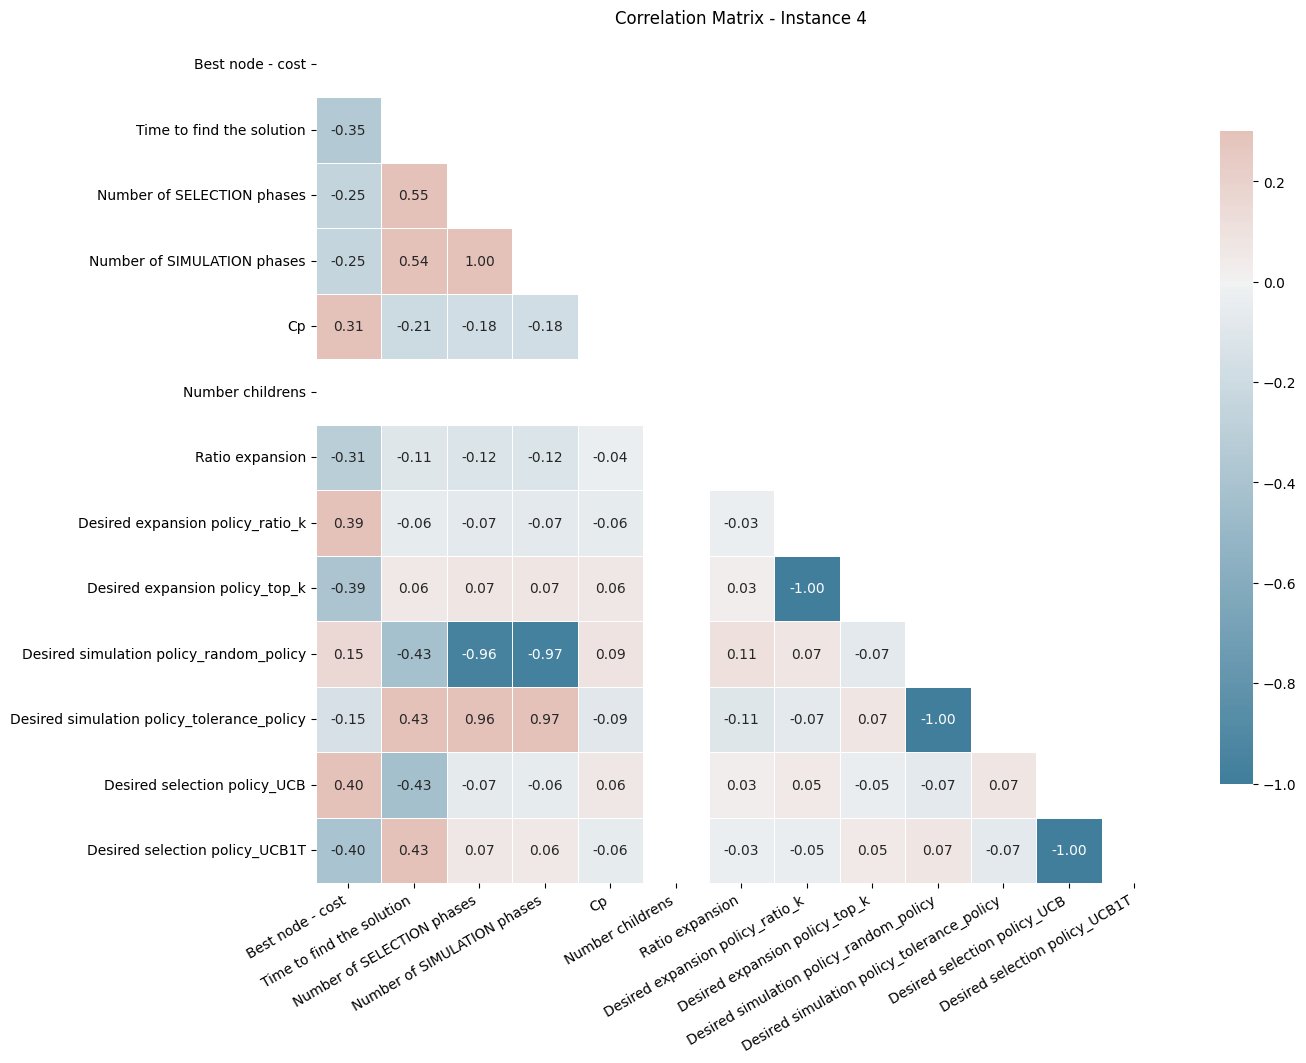

In [ ]:
DV.correlation_matrix()

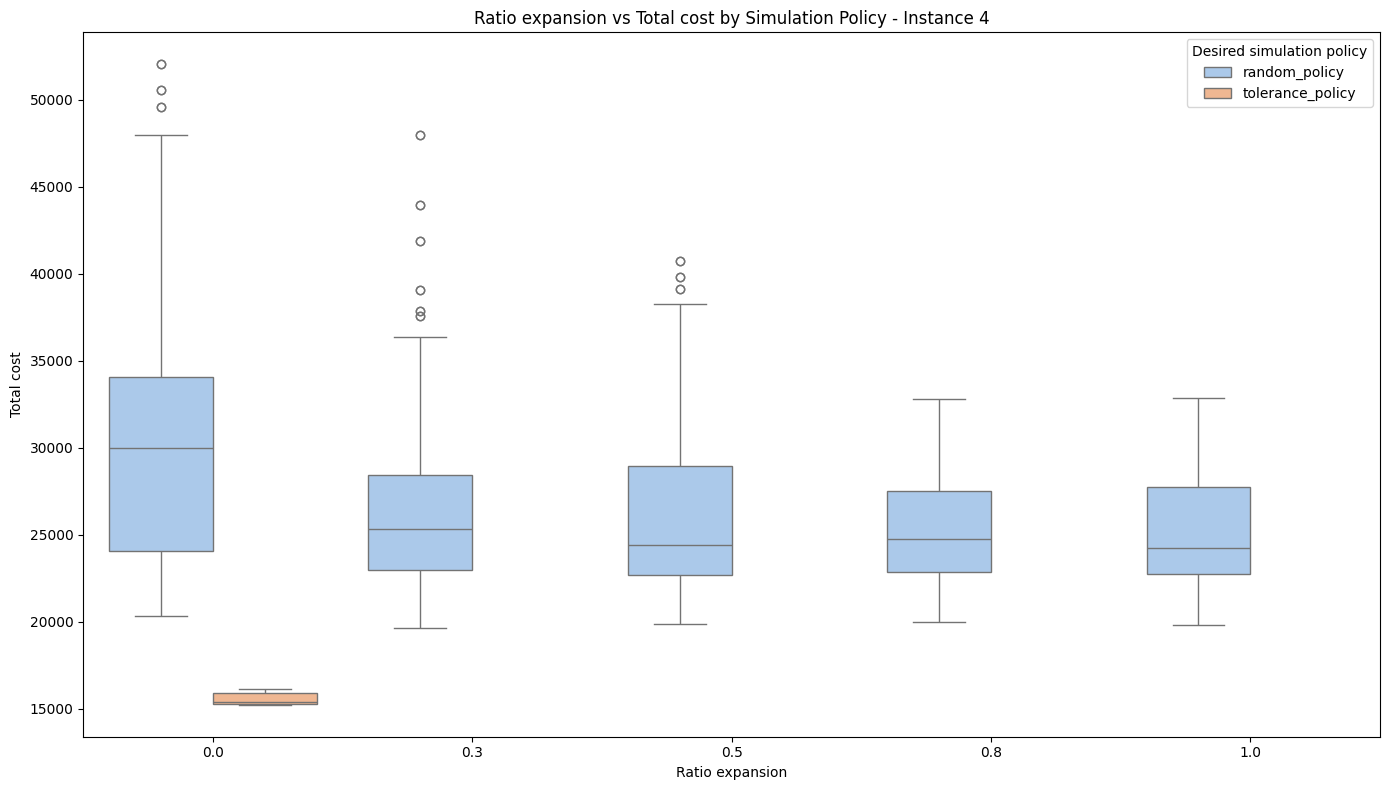

In [ ]:
DV.simulation_vs_cost()

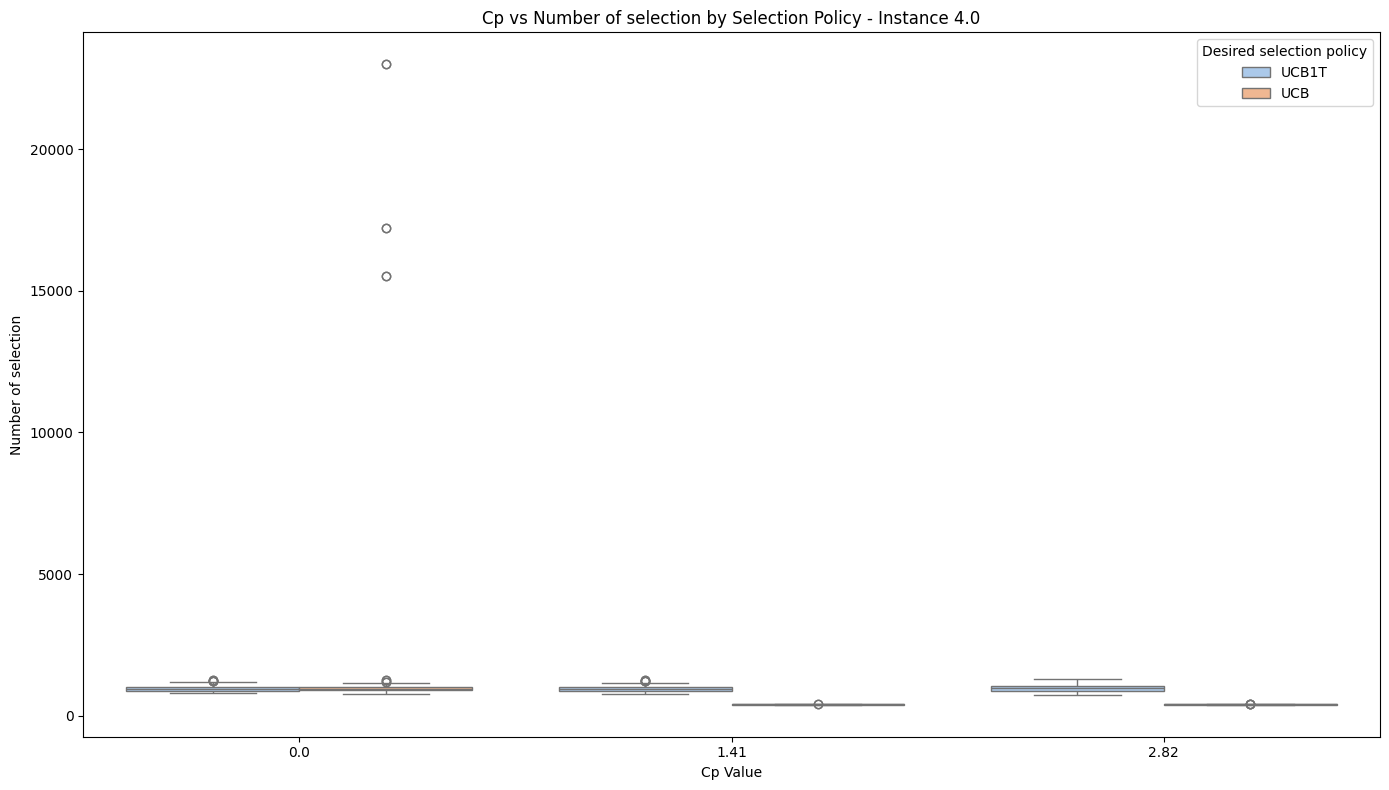

In [ ]:
DV.cp_vs_selection()

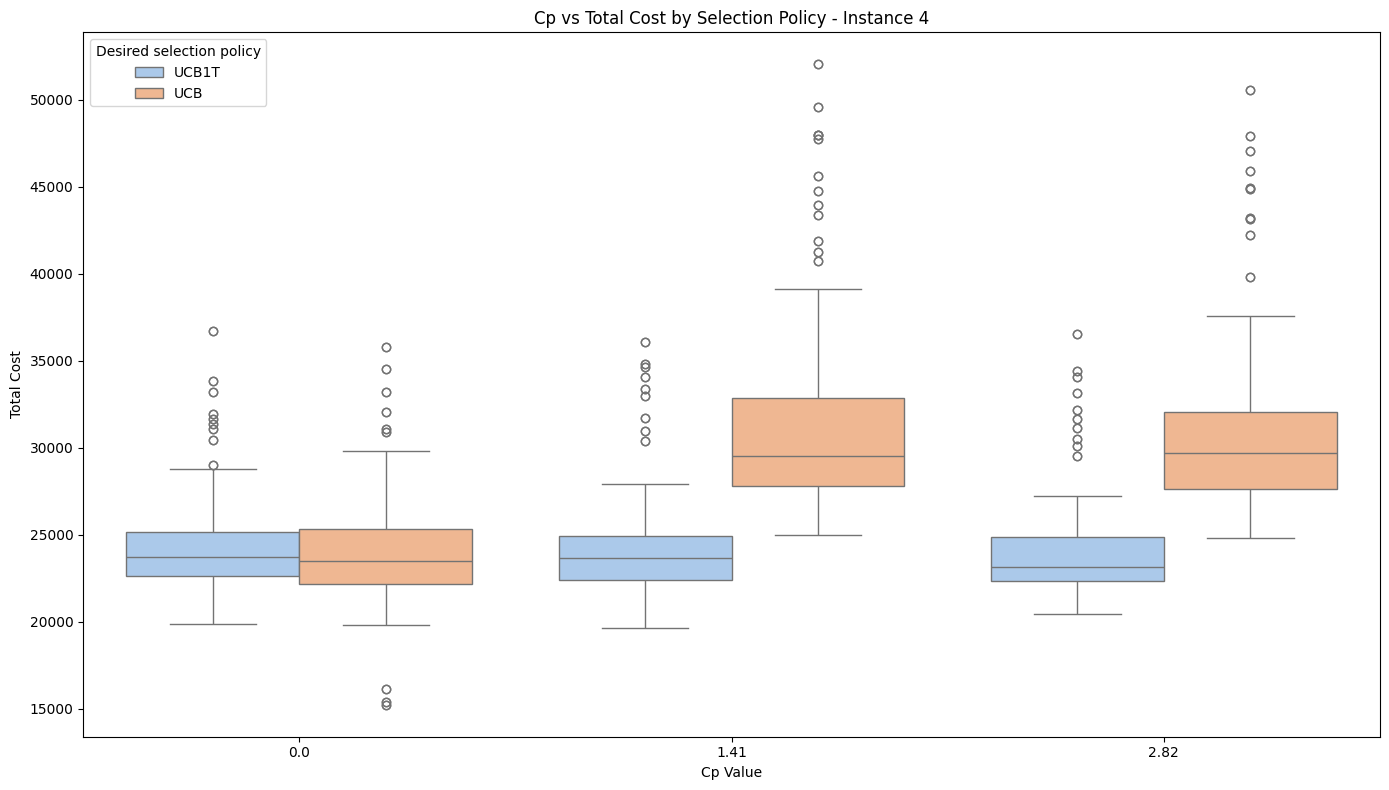

In [ ]:
DV.cp_vs_cost()

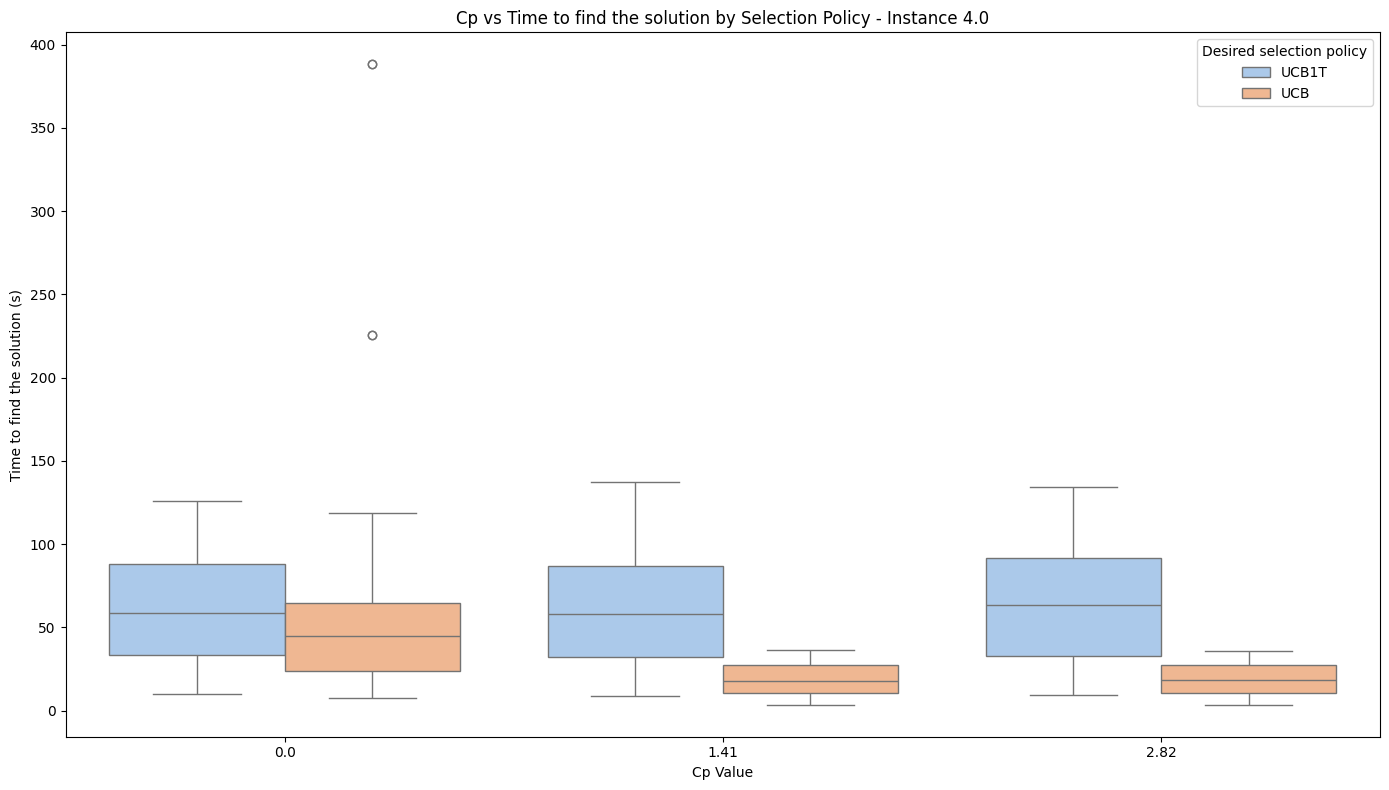

In [ ]:
DV.cp_vs_time()

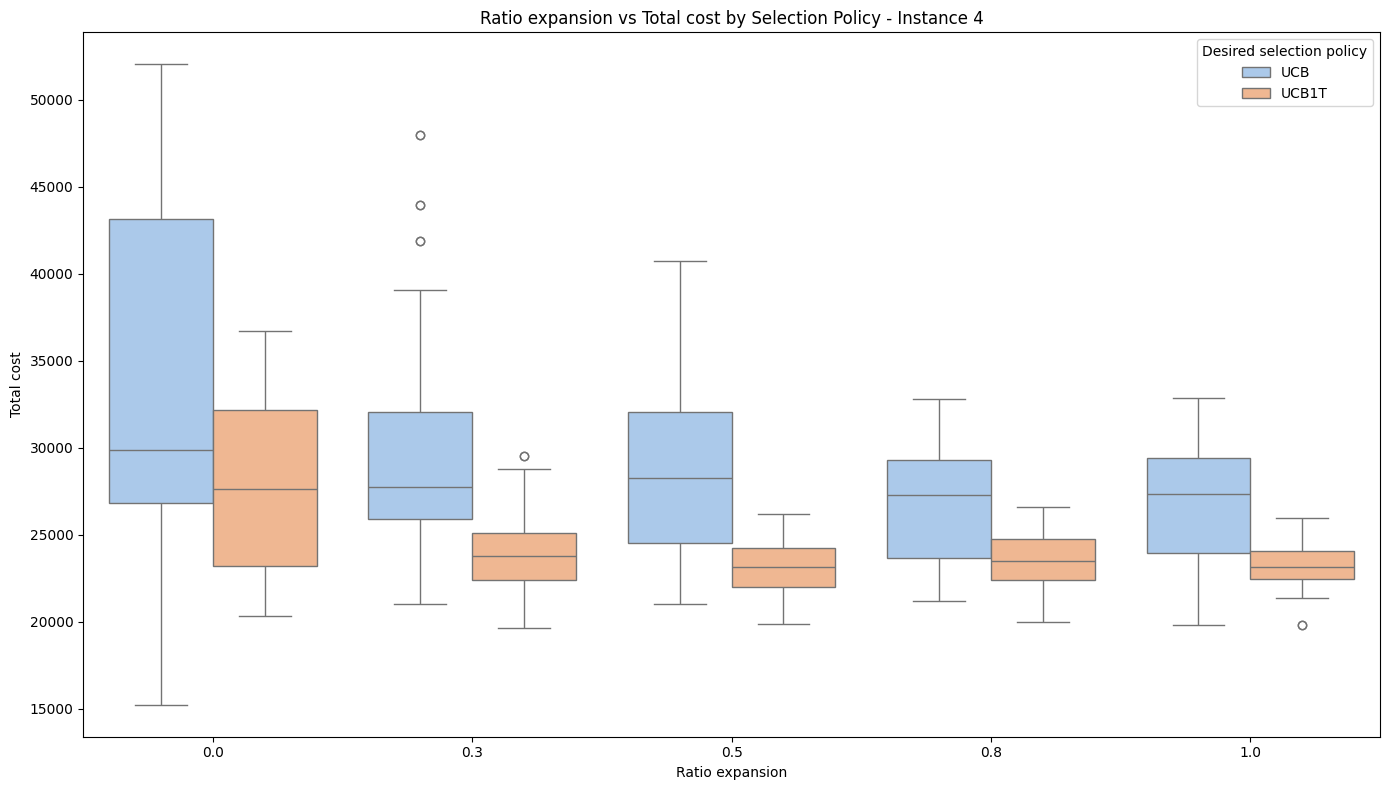

In [ ]:
DV.ratio_vs_cost()

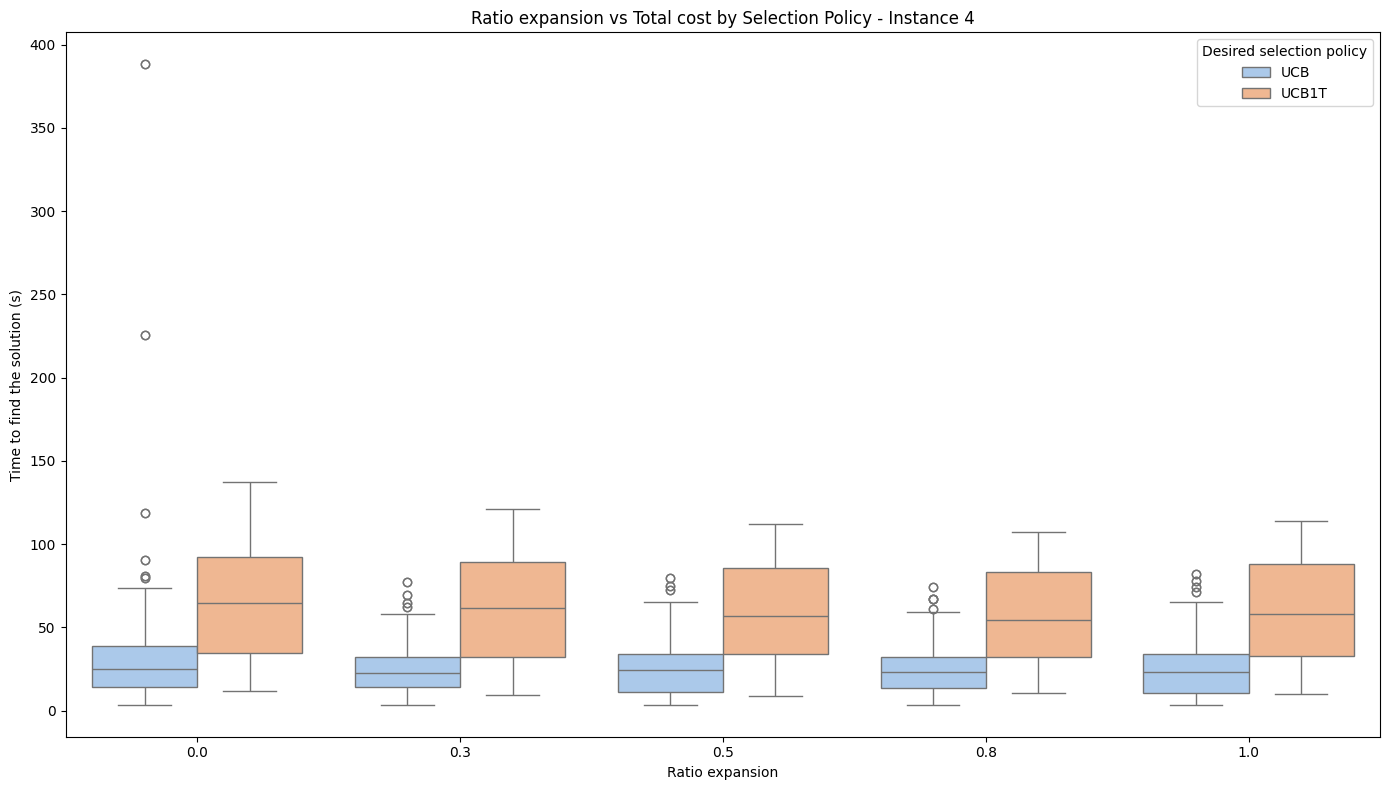

In [ ]:
DV.ratio_vs_time()

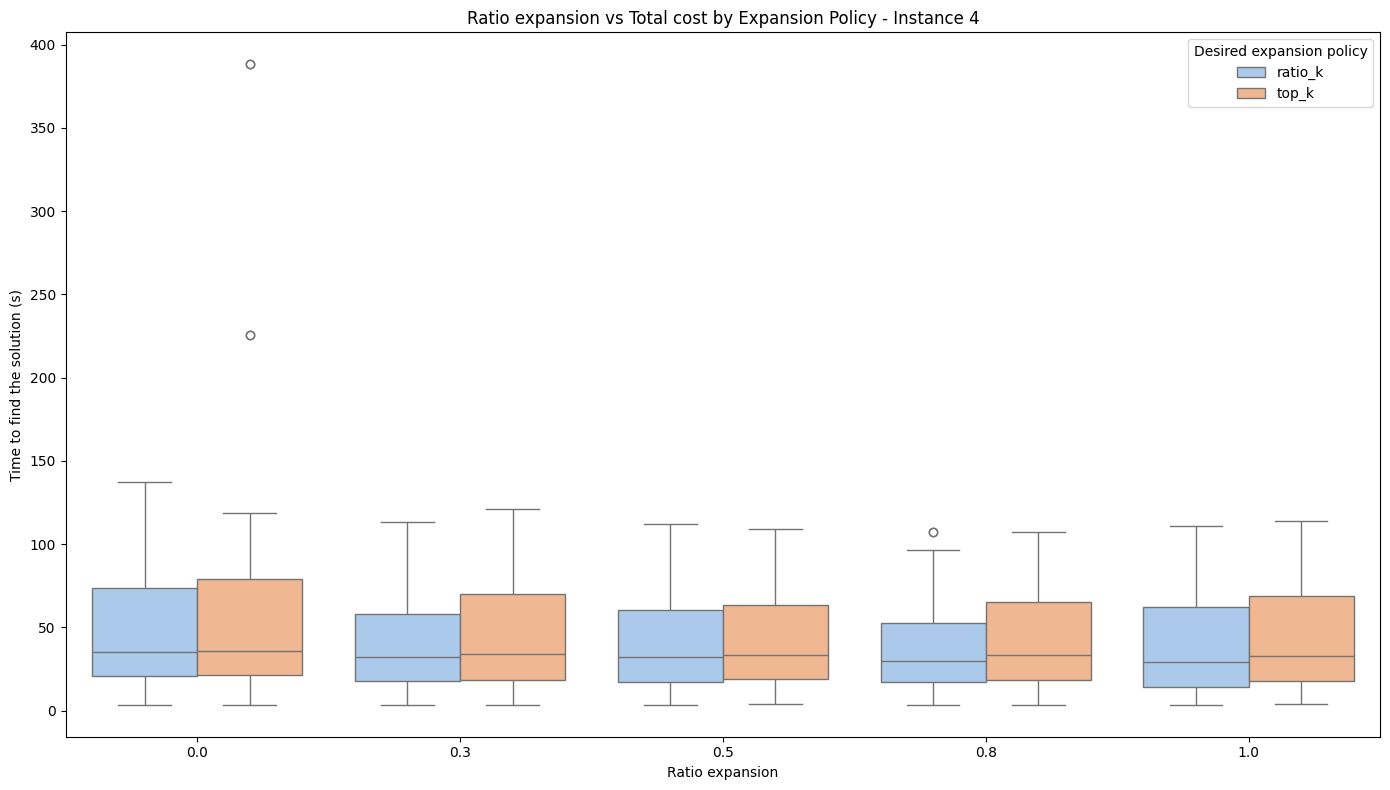

In [ ]:
DV.expansion_vs_time()

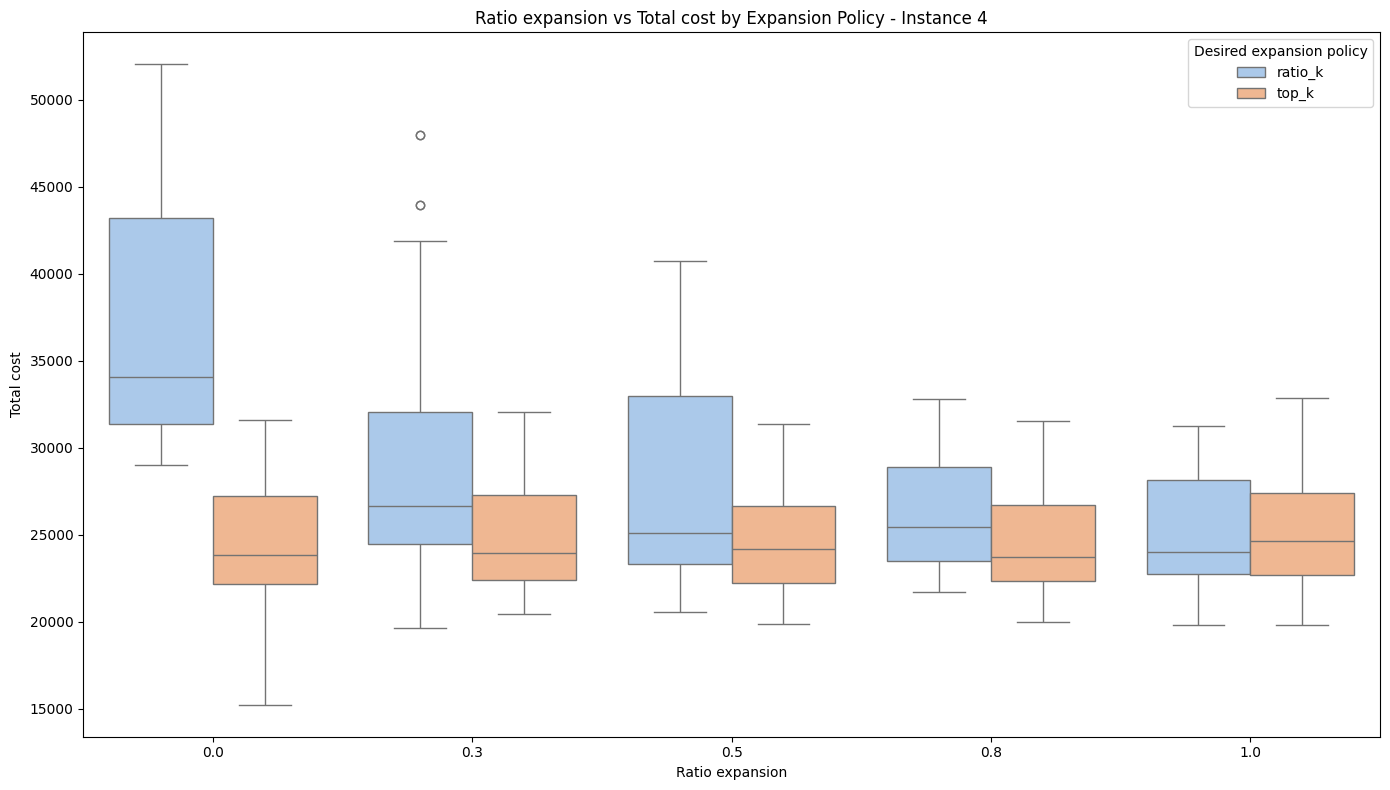

In [ ]:
DV.expansion_vs_cost()

In [ ]:
DV.best_result()

/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_22246/1857854943.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Best node - cost'] = self.df['Best node - cost'].replace("", np.nan)
/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_22246/1857854943.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Best node - cost'] = pd.to_numeric(self.df['Best node - cost'], errors='coerce')
/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_22246/1857854943.py:74: Dep

,Desired selection policy,Desired expansion policy,Desired simulation policy,Number childrens,Ratio expansion,Cp,Best node - cost,mean,std,Time to find the solution
57,UCB,top k,tolerance,10,0.0,0.00,15235,15578.00,418.49,118.4299
19,UCB1T,ratio k,random,10,0.3,1.41,19661,25064.11,2431.80,44.9168
12,UCB,ratio k,random,10,1.0,0.00,19803,22054.00,1766.30,63.0142
55,UCB1T,top k,random,10,1.0,1.41,19824,23286.11,1670.38,62.9323
48,UCB1T,top k,random,10,0.5,0.00,19864,22779.33,1675.41,54.9540
51,UCB1T,top k,random,10,0.8,0.00,19999,23058.44,1853.77,41.7100
42,UCB1T,top k,random,10,0.0,0.00,20349,23215.67,1858.56,89.2809
47,UCB1T,top k,random,10,0.3,2.82,20456,22168.11,977.57,111.8881
22,UCB1T,ratio k,random,10,0.5,1.41,20546,23069.00,1706.84,75.6782
27,UCB,top k,random,10,0.0,0.00,20645,23028.44,1875.37,30.8338
